In [11]:
import sys

sys.path.insert(0, '/Volumes/data/LosAlamosSummer')
sys.path.insert(0, '/Volumes/data/LosAlamosSummer/DrOsborneCode')

import Utilities as ut
import importlib
import model as mod
import predict_with_uncertainty as pu
import custom as cus
importlib.reload(ut)
importlib.reload(mod)
importlib.reload(pu)
importlib.reload(cus)
import scipy
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [5]:
#datapath = '/Users/jessiejo/data/VBUDS/GroupStructurePaper/NeuralNetworks/All_Libraries/NewDataSetFull1.mat'
datapath='/Volumes/data/LosAlamosSummer/LWR/DATA/LWR_data_7.mat'
print('Loading In Data')
kinfBOL,kinfMOL,kinfEOL,GS=ut.LoadData(datapath,1)
#MakeGroupDensity(X, nDecades)
Nfeatures = 1000;
allData= ut.ProcessData(datapath, 1,1000,0,0,1)
# allData: (100,000x1,000) y_direct: (100,000x3)
print('Finished Loading Data')

Loading In Data
Finished Loading Data



Load Data loads raw data from the .mat file
Inputs
datapath: Path to .mat file containing the data [string]
BU: whether the data contains burnup; 1=burnup, 0=no burnup [bool]

ProcessData is the serialization maker 
Inputs
datapath: Path to .mat file containing the data [string]
Percent of data to be used: in most cases full data set will be used but good for analysis [double](0-1)
ndecades: Number of decades wanted in equal lethargy serialization. Number is ignored if custom serialization inputted [int]
mode: equal lethargy mode (0) or custom serialization mode (1) [boolean]
input serial: a custom serialization regime (ignored if mode is not 1) [numpy array]
BU: whether the data contains burnup; 1=burnup, 0=no burnup [bool]

In [7]:

#!pip install -q -U keras-tuner
print(kinfBOL.shape)
print(len(kinfBOL))
kinf=np.array(np.zeros((len(kinfBOL),3)))
kinf[:,0]=kinfBOL
kinf[:,1]=kinfMOL
kinf[:,2]=kinfEOL#np.concatenate((kinfBOL,kinfMOL,kinfEOL),axis=0)
print(kinf.shape)
print(np.std(kinfBOL))

(49999,)
49999
(49999, 3)
0.25062617612169336


In [8]:
Nsamples,Ndecades = allData.shape
vldF=.1
testF=.2
normConst=1#np.linalg.norm(kinf)
y_norm=np.array(kinf/normConst)

X, X_test, y, y_test, vldF_corr = ut.makeFractions(Nsamples, vldF, testF, allData, y_norm, 1)


NtrainingSamples = int(Nsamples*(1 - testF))
tranValSplit=int(NtrainingSamples*(1-vldF_corr))
X_train=X[:tranValSplit,:]
y_train=y[:,:tranValSplit]
X_val=X[tranValSplit+1:,:]
y_val=y[:,tranValSplit+1:]
print(y_test.shape)
print(y_val.shape)
print(y_norm.shape)
print(y_train.shape)

(3, 9999)
(3, 4999)
(49999, 3)
(3, 34999)


makeFractions splits the data into appropriatly sized sets
Nsamples is the number of samples of the data set
vldF is the validation fraction
testF is the test fraction
allData is the set of serialzed group structures
y_norm is the kinfs that correspond to the serialized group structures (normalized or otherwise)
BU (the last input) is a boolean determining whether the data contains burnup [Boolean] (used in the same manner as previous)

In [143]:
batch_size=110;
model = tf.keras.Sequential([
    layers.Dense(173, activation='elu', name='hidden_1', input_dim=999),
    layers.Dense(460, activation='elu',  name='hidden_2'),
    layers.Dense(3, activation='linear',name='output')])
model.compile(loss="mean_squared_logarithmic_error",metrics="mean_squared_logarithmic_error")
model.build()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 173)               173000    
_________________________________________________________________
hidden_2 (Dense)             (None, 460)               80040     
_________________________________________________________________
output (Dense)               (None, 3)                 1383      
Total params: 254,423
Trainable params: 254,423
Non-trainable params: 0
_________________________________________________________________


In [157]:
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-3))
model.fit(X_train,y_train.T, epochs=100, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-4))
model.fit(X_train,y_train.T, epochs=100, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-5))
model.fit(X_train,y_train.T, epochs=100, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(1e-6))
model.fit(X_train,y_train.T, epochs=100, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())

Epoch 1/100
319/319 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0189
Epoch 2/100
319/319 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0151
Epoch 3/100
319/319 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0171
Epoch 4/100
319/319 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 0.0152
Epoch 5/100
319/319 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0152
Epoch 6/100
319/319 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0168
Epoch 7/100
319/319 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0151
Epoch 8/100
319/319 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0152
Epoch 9/100
319/319 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0152
Epoch 10/100
319/319 [==============================] - 1s 2ms/step - loss: 0.0063 - val_lo

319/319 [==============================] - 1s 3ms/step - loss: 0.0049 - val_loss: 0.0139
Epoch 82/100
319/319 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0128
Epoch 00082: early stopping
Epoch 1/100
319/319 [==============================] - 1s 3ms/step - loss: 0.0029 - val_loss: 0.0122
Epoch 2/100
319/319 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0121
Epoch 3/100
319/319 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 4/100
319/319 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 0.0120
Epoch 5/100
319/319 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 0.0121
Epoch 6/100
319/319 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0121
Epoch 7/100
319/319 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 0.0120
Epoch 8/100
319/319 [==============================] - 1s 3ms/step - loss:

In [158]:
y_predicted = model.predict(X_test)
metric = tf.keras.metrics.MeanSquaredError(name="mean_average_error", dtype=None)
metric.update_state(np.array(y_predicted*normConst),np.array(y_test.T*normConst))
print(metric.result().numpy())
print(y_predicted)

0.000965601
[[1.3720028  1.0877657  0.8926724 ]
 [1.3688792  1.0894364  0.8948215 ]
 [0.92203975 0.6882773  0.54573214]
 ...
 [1.3613952  1.0700885  0.86741704]
 [1.3682325  1.0819782  0.87622315]
 [0.821684   0.6245683  0.49963948]]


In [159]:
from matplotlib import pyplot as plt
import numpy as np


(9999, 3)


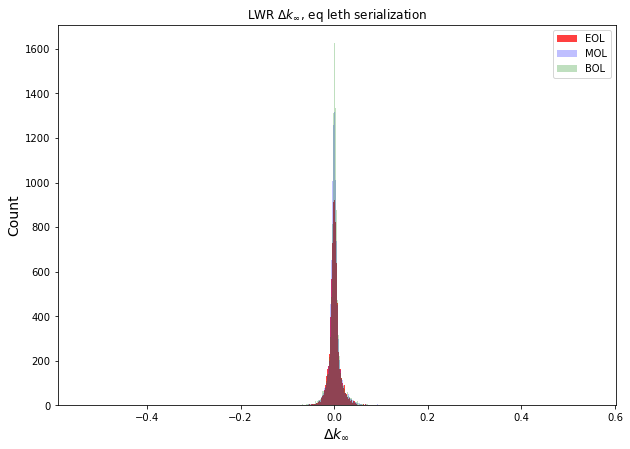

In [160]:
# Creating dataset
a = (y_predicted-y_test.T)
print(a.shape)
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a[:,2],bins=500,alpha=0.75,label="EOL",color='r')
ax.hist(a[:,1],bins=500,alpha=0.25,label="MOL",color='b')
ax.hist(a[:,0],bins=500,alpha=0.25,label="BOL",color='g')
plt.xlabel("$Δk_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.title("LWR $Δk_{\infty}$, eq leth serialization")
plt.legend(loc='upper right')
plt.savefig("PICS/LWR_completeData_eqleth_log_drOLR_narrow.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')
# Show plot
plt.show()


In [161]:

print(np.std(a[:,0]))
print(np.std(a[:,1]))
print(np.std(a[:,2]))
print(np.mean([np.std(a[:,0]),np.std(a[:,1]),np.std(a[:,2])]))
print(np.std(a,0))

0.03326340912491529
0.03162610220745287
0.02810893159587137
0.03099948097607984
[0.03326341 0.0316261  0.02810893]


In [107]:
print(y_predicted[:,0])
print(y_predicted.shape)
print(y_test.shape)

[1.3714604  1.3617232  0.9090312  ... 1.3582966  1.3679968  0.80100185]
(9999, 3)
(3, 9999)


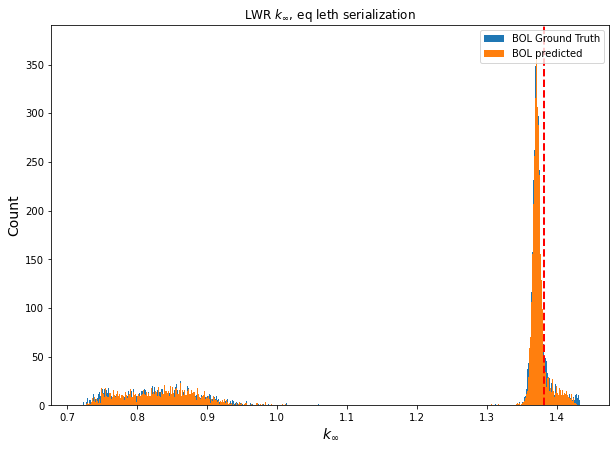

In [163]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
 

n_bins = 1000
 

# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(y_test.T[:,0], bins = n_bins,label="BOL Ground Truth")
axs.hist(y_predicted[:,0], bins = n_bins,label="BOL predicted")


plt.xlabel("$k_{\infty}$", size=14)
plt.ylabel("Count", size=14)

plt.legend(loc='upper right')
plt.axvline(1.3815,color='r',linestyle='dashed',linewidth=2)

plt.title("LWR $k_{\infty}$, eq leth serialization")
plt.savefig("PICS/kinfPredDist_boxlog_drOLR_narrow.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')
plt.show()
# Show plot



In [133]:
print(np.sum(np.logical_and(kinfBOL > 1.3815-0.001,kinfBOL < 1.3815+0.001))/50000)

print(len(kinfBOL))

0.01676
49999


In [128]:
np.sum(a[:,0]<0.001)

5741

In [114]:
len(a)

9999

In [123]:
5741/9999


0.5741574157415742